# TP 8 OPTIONS
## Data preparation and models

In this exercice, we use simple MLP model. <br>
Prepare data in one shot.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from abc import abstractmethod
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, LeakyReLU, LSTM
import tensorflow.keras.backend as K
from sklearn.metrics import mean_squared_error
from scipy.stats import norm

class OptionPricer:
    def __init__(self, epochs=100, batch_size=64, train_ratio=0.8, is_eval=False):
        # self.win_size = win_size
        # self.x_size = x_size
        self.is_eval = is_eval
        self.batch_size = batch_size
        self.train_ratio = train_ratio
        self.epochs = epochs

    @abstractmethod
    def _model(self):
        pass

    def prepare(self, data, predictors, target='mid_option'):
        if target in predictors:
            raise Exception('target label is in predictors')
        self.x_size = len(predictors)
        self.model = self._model()
        for p in predictors:
            if p not in data.columns:
                raise Exception('predictor not found')
        self._split_set(data, predictors, target)
    
    def train(self):
        print('*** model training started ***')
        history = self.model.fit(self.X, epochs=self.epochs, verbose=0)
        print('*** model training done ***')
        plt.plot(np.log(history.history['loss']))
        plt.xlabel('epoch')
        plt.ylabel('log(mse)')
        plt.show()

    def test(self):
        prediction = self.model(self.tsamples, training=False)
        plt.figure(figsize=(12, 6))

        ax1 = plt.subplot(121)
        ax1.set_title('Prediction test')
        ax1.scatter(self.tlabels, prediction, marker='+', linewidths=0.5)
        ax1.plot(self.tlabels, self.tlabels, c='r')
        ax1.set_xlabel('Real values')
        ax1.set_ylabel('Predictions')

        err = (self.tlabels.flatten() - prediction.numpy().flatten())
        ax2 = plt.subplot(122)
        ax2.hist(err, bins = 1000)
        ax2.set_xlabel('error')
        ax2.set_ylabel('distribution')
        ax2.set_ylim((0, np.max(err) + 10))
        plt.show()
        return
	
    def _split_set(self, data, predictors, target):
        p = int(self.train_ratio * len(data))

        samples = data[predictors].iloc[:p].values # p * x_size
        labels = data[target].iloc[:p].values # p * 1
        print('train batch: %s*%s, train set shape: %s, train target shape: %s' %
          (self.batch_size, len(samples) // self.batch_size, samples.shape, labels.shape))
        self.X = tf.data.Dataset\
                        .from_tensor_slices((samples, labels))\
                        .shuffle(samples.shape[0])\
                        .batch(self.batch_size)

        self.tsamples = data[predictors].iloc[p:].values
        self.tlabels = data[target].iloc[p:].values


class DenseOptionPricer(OptionPricer):
    def __init__(self,epochs=100, batch_size=64, train_ratio=0.8, is_eval=False):
        super().__init__(epochs, batch_size, train_ratio, is_eval)


    def _model(self):
        mod = Sequential([
            Dense(10, input_shape=(self.x_size,), activation='relu'),
            Dense(10, activation='tanh'),
            Dense(10, activation='tanh'),
            Dense(10, activation='relu'),
            Dense(1, activation='relu')
        ])

        mod.compile(loss=tf.losses.MeanSquaredError(),
                        optimizer=tf.optimizers.Adam(),
                        metrics=[tf.metrics.MeanAbsoluteError()])
        print(mod.summary())
        return mod


def get_data(path):
    df = pd.read_csv(path, index_col=None).dropna()
    df = df[df['option_type'] == 'call']
    df['index'] = pd.to_datetime(df['index'])
    # df['index'] = (df['index'] - pd.Timestamp('2009-03-09 15:00:00')).astype('timedelta64[D]')
    df["mid_option"] = (df['bid'] + df['ask']) / 2

    df['vol7'] = df[['index', 'mid']].rolling('7D', min_periods=1, on='index').std()['mid']
    df['vol7_option'] = df[['index', 'mid_option']].rolling('7D', min_periods=1, on='index').std()['mid_option']
    df['vol14'] = df[['index', 'mid']].rolling('14D', min_periods=1, on='index').std()['mid']
    df['vol14_option'] = df[['index', 'mid_option']].rolling('14D', min_periods=1, on='index').std()['mid_option']
    df['vol49'] = df[['index', 'mid']].rolling('49D', min_periods=1, on='index').std()['mid']
    df['vol49_option'] = df[['index', 'mid_option']].rolling('49D', min_periods=1, on='index').std()['mid_option']

    df['spread_option'] = (df['ask'] - df['bid']) / df['mid'] * 100 
    df['k'] = df['strike'] / df['mid']
    df['days_to_expiry']=(df['days_to_expiry']-df['days_to_expiry'].min())/(df['days_to_expiry'].max()-df['days_to_expiry'].min())

    df = df.dropna()
    # df[[ 'k']].plot()
    # plt.show()
    return df

def get_data_bs(df):
    t = df['days_to_expiry'] / 252
    sigma = df['vol49'] / df['mid']
    d1 = (np.log(df['mid']/df['strike']) + t*sigma ** 2 / 2)/(sigma * np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)
    call = df['mid'] * norm.cdf(d1) - df['strike'] * norm.cdf(d2)
    df['bs'] = call

    return df

## 1 Incomplet predictors
The training does not converge when only using k and expiry.

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_51 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_52 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_53 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 11        
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________
None
train batch: 64*752, train set shape: (48160, 2), train target shape: (48160,)
*** model training started ***
*** mo

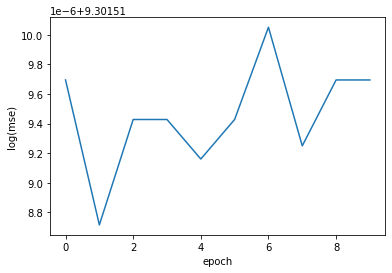

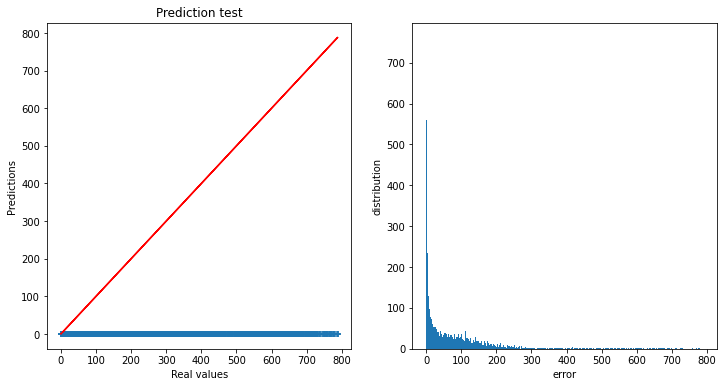

In [ ]:
d = get_data('/content/drive/MyDrive/Colab Notebooks/TP8_ES_options.csv')
pricer = DenseOptionPricer(epochs=10)
pricer.prepare(d, ['k', 'days_to_expiry'])
pricer.train()
pricer.test()


## 2 Incomplet predictors + spreads
With spreads, the training starts to converge. But we have a loss when the real price becomes larger.

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 10)                40        
_________________________________________________________________
dense_46 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_47 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_48 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 11        
Total params: 381
Trainable params: 381
Non-trainable params: 0
_________________________________________________________________
None
train batch: 64*752, train set shape: (48160, 3), train target shape: (48160,)
*** model training started ***
*** mod

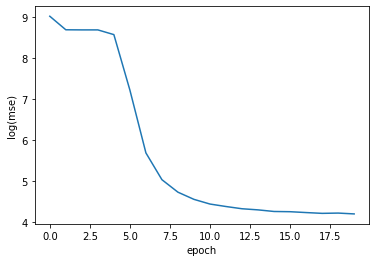

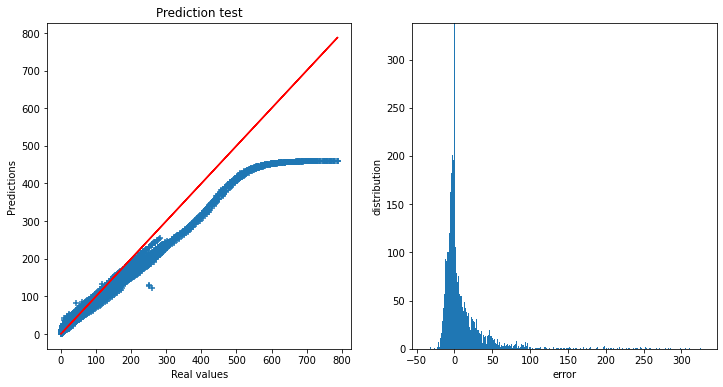

In [ ]:
d = get_data('/content/drive/MyDrive/Colab Notebooks/TP8_ES_options.csv')
pricer = DenseOptionPricer(epochs=20)
pricer.prepare(d, ['k', 'days_to_expiry', 'spread_option'])
pricer.train()
pricer.test()

## 3 Incomplet predictors + spreads + volatility
### Use solely 49-days volatility

Here, I have compared the performance of volatility of different window sizes. It shows that with 49-days volability or with multiple volabilities, we can obtain a relatively better performance. Though as the real price becomes larger, there will still be a loss.

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 10)                50        
_________________________________________________________________
dense_36 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_37 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_38 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 11        
Total params: 391
Trainable params: 391
Non-trainable params: 0
_________________________________________________________________
None
train batch: 64*752, train set shape: (48160, 4), train target shape: (48160,)
*** model training started ***
*** mod

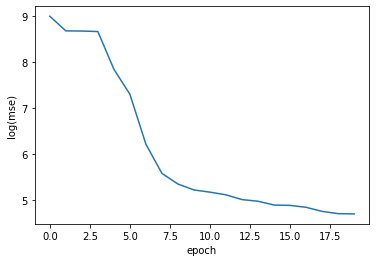

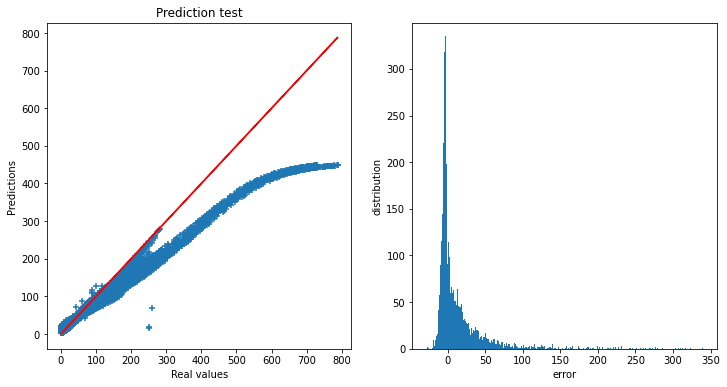

In [ ]:
d = get_data('/content/drive/MyDrive/Colab Notebooks/TP8_ES_options.csv')
pricer = DenseOptionPricer(epochs=20)
pricer.prepare(d, ['k', 'days_to_expiry', 'spread_option', 'vol49'])
pricer.train()
pricer.test()

### Use multiple volatilities

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 10)                70        
_________________________________________________________________
dense_26 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_27 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_28 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 11        
Total params: 411
Trainable params: 411
Non-trainable params: 0
_________________________________________________________________
None
train batch: 64*752, train set shape: (48160, 6), train target shape: (48160,)
*** model training started ***
*** mod

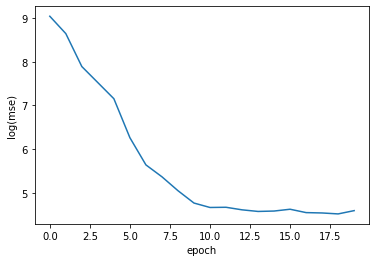

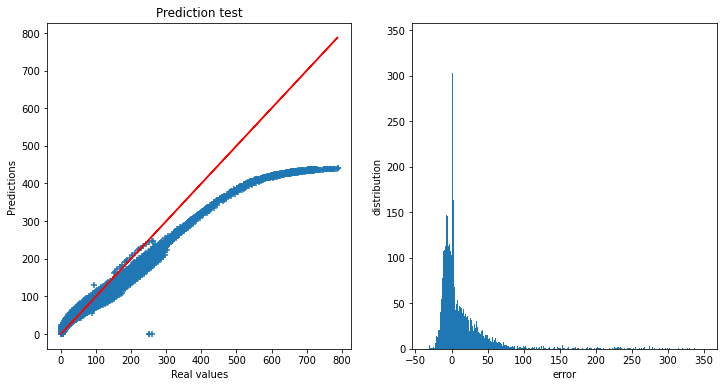

In [ ]:
d = get_data('/content/drive/MyDrive/Colab Notebooks/TP8_ES_options.csv')
pricer = DenseOptionPricer(epochs=20)
pricer.prepare(d, ['k', 'days_to_expiry', 'spread_option','vol7','vol14', 'vol49'])
pricer.train()
pricer.test()

## 4 Incomplet predictors + spreads + volatility + Black Scholes

Black-Scholes prediction is proved as a quite efficient predictor to eliminate the loss to some degree. The evaluation values stick more close to real values. 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_21 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_22 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_23 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 11        
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________
None
train batch: 64*752, train set shape: (48160, 5), train target shape: (48160,)
*** model training started ***
*** mod

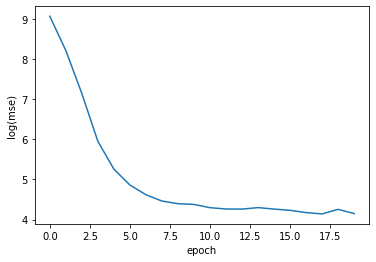

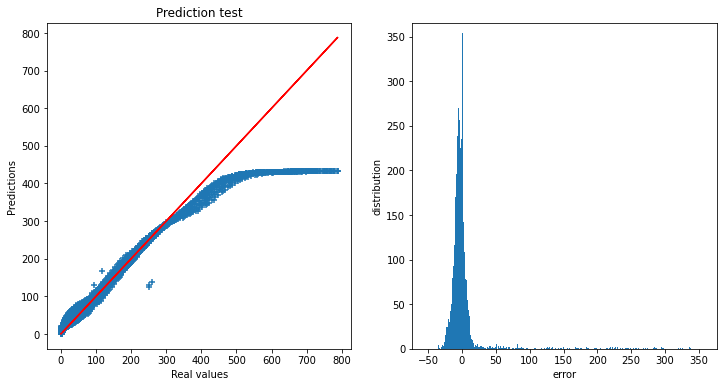

In [ ]:
d = get_data('/content/drive/MyDrive/Colab Notebooks/TP8_ES_options.csv')
d = get_data_bs(d)
pricer = DenseOptionPricer(epochs=20)
pricer.prepare(d, ['k', 'days_to_expiry', 'spread_option', 'vol49', 'bs'])
pricer.train()
pricer.test()